In [1]:
import typing as tp
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Классный [блог-пост](https://dyakonov.org/2019/10/31/линейная-регрессия/) от А. Дьяконова для тех, кто хочет копнуть поглубже

In [2]:
data = load_boston()

In [3]:
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
x = data['data']
y = data['target']

In [5]:
x = pd.DataFrame(data['data'], columns=data['feature_names'])

In [6]:
x

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.98  
1       17.8  396.90   9.14  
2       17.8  392.83   4.03  
3       18.7  394.63   2.94  
4       18.7  396.90   5.33  
..       ...     ...    ...  
501     21.0  391.99   9.67  
502     21.0  396.90   9.08  
503     21.0  396.90   5.64  
504     21.0  393.45   6.48  
505     21.0  396.90   7.88  

[506 rows x 13 columns]

In [8]:
x.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

### Посмотрим, как распределены признаки

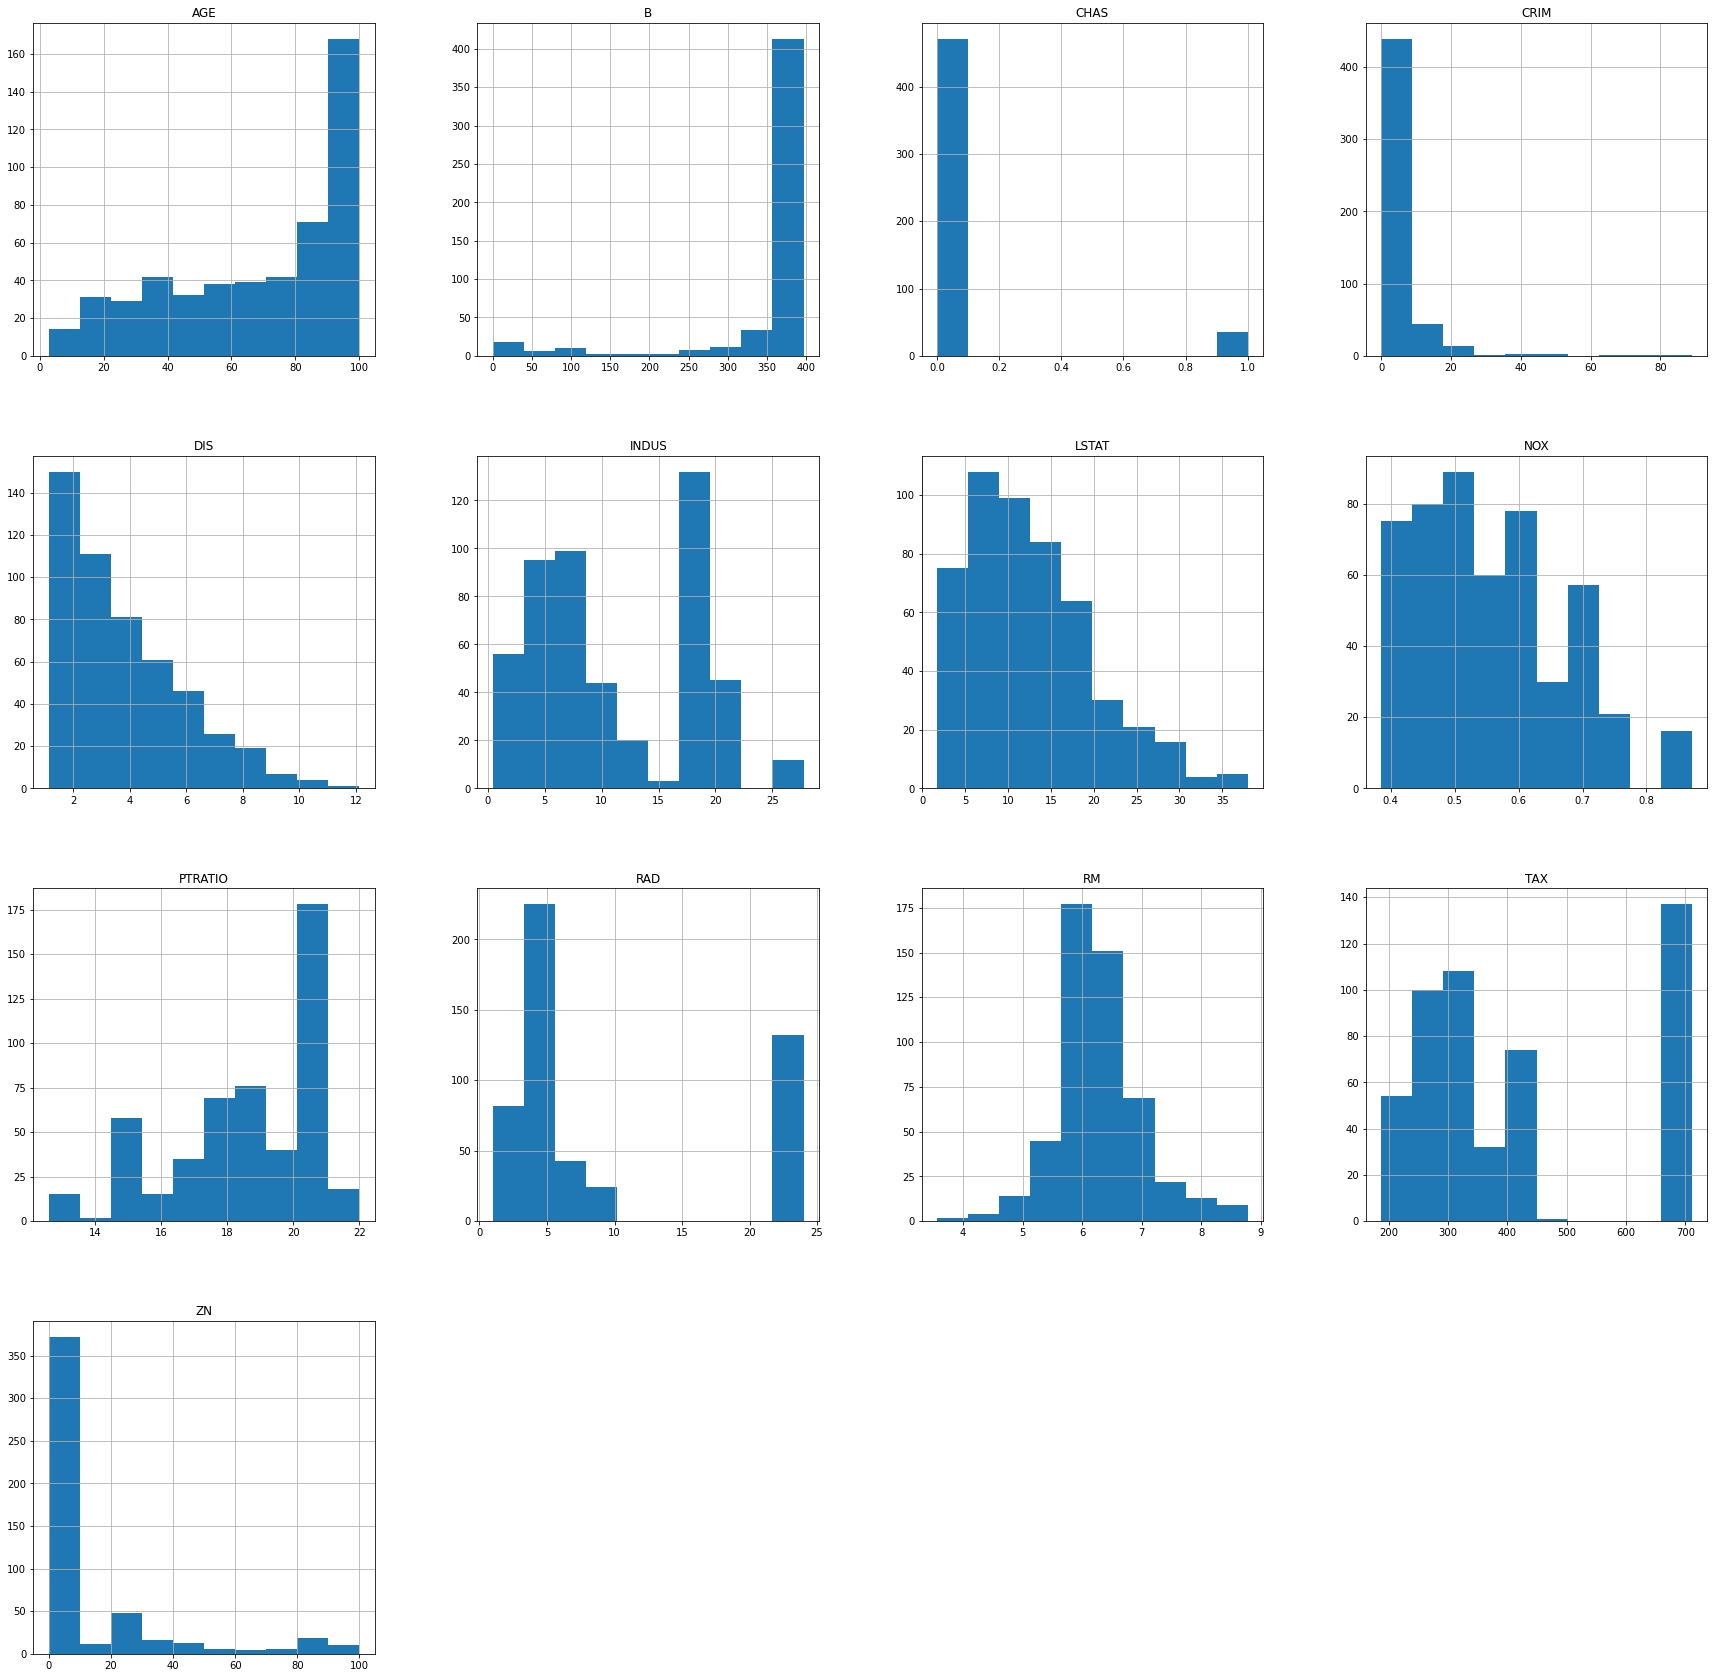

In [9]:
x.hist(figsize=(30, 30));

### Разобьем наши данные на тренировочную и тестовую выборки:

![](https://algotrading101.com/learn/wp-content/uploads/2020/06/training-validation-test-data-set.png)

На тренировочной выборке мы тренируем (ваш кэп) модель, а на валидационной будем оценивать ее качество (метрики).

In [11]:
def split_train_test(
    x: pd.DataFrame,
    y: np.ndarray,
    test_size: float = 0.2,
    random_state: int = 42,
) -> tp.Tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    return x_train, x_test, y_train, y_test

In [10]:
x_train, x_test, y_train, y_test = split_train_test(x, y)

### Зачем мы это делаем:

Зеленым нарисована истинная зависимость.

Синим - выборка из точной зависимости + шум.

Красным - построенная по этим данным модель.

Модель хорошая? Почему?

![](https://i.stack.imgur.com/JezCW.png)


Мы хотим оценивать качество нашей модели. Т.е. уметь понимать, как проявит себя модель на данных, которые она не видела.

На тренировочных данных это делать плохо, потому что модель "видела" эти данные. Т.е. мы решали оптимизационную задачу и параметры модели подбирались таким образом, чтобы "угодить" на тренировочной выборке. Но оптимальность на тренировочной выборке совершенно не означает хорошее качество на новых данных.

Например, можно придумать такую модель машинного обучения: запомним все признаки каждого объекта 

```python
def get_model(x_train: np.ndarray, y_train: np.ndarray) -> dict:    
    model = {}
    for i in range(len(x_train)):
        model[tuple(x_train[i])] = y[i]
    return model
```

А предсказывать она будет так:

```python
def predict(model: dict, x: np.ndarray) -> float:
    return model[tuple(x)]
```

На тренировочной выборке качество у такой модели будет идеальным. Но на новых данных мы от этой модели ничего кроме ``` KeyError``` не получим

### Копипаста из [википедии](https://ru.wikipedia.org/wiki/Переобучение) про переобучение:

Переобучение (переподгонка, пере- в значении «слишком», англ. overfitting) в машинном обучении и статистике — явление, когда построенная модель хорошо объясняет примеры из обучающей выборки, но относительно плохо работает на примерах, не участвовавших в обучении (на примерах из тестовой выборки).

Это связано с тем, что при построении модели («в процессе обучения») в обучающей выборке обнаруживаются некоторые случайные закономерности, которые отсутствуют в генеральной совокупности.

Иными словами - модель запоминает огромное количество всех возможных примеров вместо того, чтобы научиться подмечать особенности.

Даже тогда, когда обученная модель не имеет чрезмерного количества параметров, можно ожидать, что эффективность её на новых данных будет ниже, чем на данных, использовавшихся для обучения[1]. В частности, значение коэффициента детерминации будет сокращаться по сравнению с исходными данными обучения.

Способы борьбы с переобучением зависят от метода моделирования и способа построения модели. Например, если строится дерево принятия решений, то можно обрезать некоторые его ветки в процессе построения.

![](https://static.packt-cdn.com/products/9781838556334/graphics/C12624_07_02.jpg)

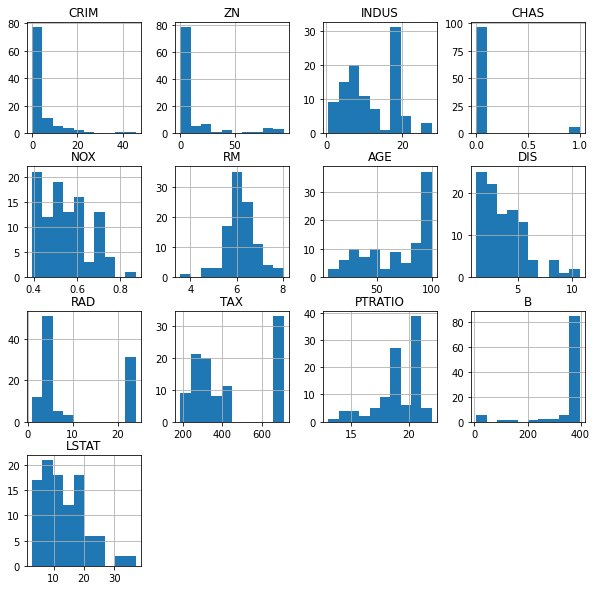

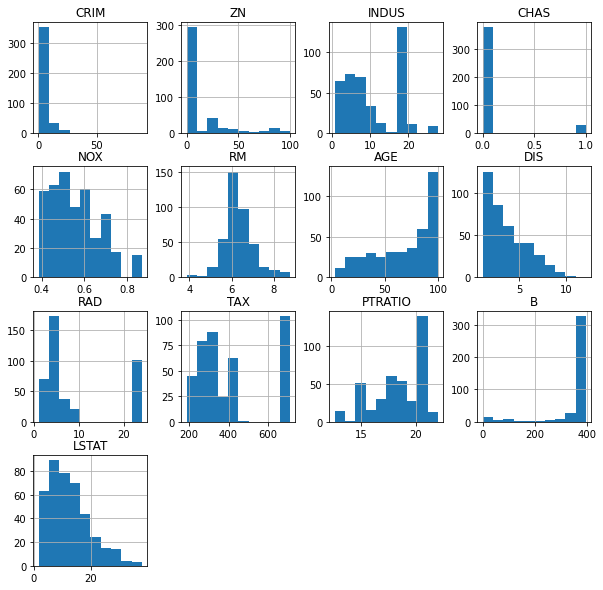

In [12]:
x_test.hist(figsize=(10, 10));
x_train.hist(figsize=(10, 10));

In [13]:
np.median(y_train), np.median(y_test), np.median(y)

(21.6, 20.15, 21.2)

### Препроцессинг данных

In [18]:
def my_scale(x):
    return (x - x.mean(0)) / x.std(0)

In [19]:
def scale_train_test(x_train: pd.DataFrame, x_test: pd.DataFrame) -> tp.Tuple[pd.DataFrame, pd.DataFrame]:
    scaler = StandardScaler()
    x_train, x_test = deepcopy(x_train), deepcopy(x_test)
    x_train.loc[:] = scaler.fit_transform(x_train)
    x_test.loc[:] = scaler.transform(x_test)
    return x_train, x_test

In [20]:
my_scaled_x_train = my_scale(np.array(x_train))
x_train, x_test = scale_train_test(x_train, x_test)
assert np.allclose(my_scaled_x_train, np.array(x_train))

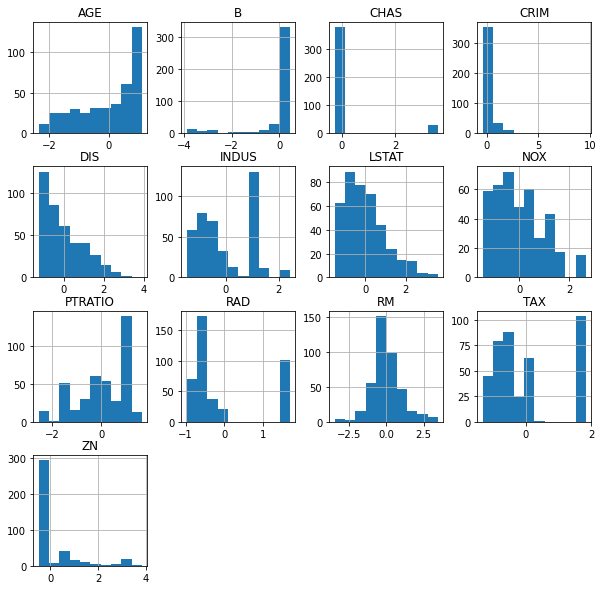

In [18]:
x_train.hist(figsize=(10, 10));

#### Почему для x_train мы делаем fit_transform, а для x_test делаем просто transform?

### Чем может быть полезна нормировка?



1. Градиентные методы обычно лучше сходятся, если признаки из +- одинаковых диапазонов

2. Можно начинать интерпретировать веса как важности признаков


### Собственно, обучим нашу модель и посмотрим на метрики

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(x_train, y_train)

predict_train = model.predict(x_train)
predict_test = model.predict(x_test)

train_mse = mean_squared_error(y_train, predict_train)
test_mse = mean_squared_error(y_test, predict_test)

train_mse, test_mse

(21.641412753226312, 24.29111947497352)

### Функция, которая подготовит данные, обучит модель и вернет метрики

In [22]:
def train_pipiline(
    model: tp.Any,
    x: pd.DataFrame,
    y: np.ndarray,
    test_size: float,
    random_state: int,
) -> tp.Tuple[LinearRegression, tp.Dict[str, float]]:
    x_train, x_test, y_train, y_test = split_train_test(x, y, random_state=random_state, test_size=test_size)
    x_train, x_test = scale_train_test(x_train, x_test)
    
    model.fit(x_train, y_train)

    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)

    train_mse = mean_squared_error(y_train, predict_train)
    test_mse = mean_squared_error(y_test, predict_test)
    
    metrics = {
        'train_mse': train_mse,
        'test_mse': test_mse,
    }
    
    return model, metrics
    

### Сгенерируем несколько выборок train/test, обучим нашу модель, посмотрим на метрики:

In [25]:
n_times = 5
test_size = 0.2
model = LinearRegression()

for i in range(n_times):
    _, metrics = train_pipiline(model, x, y, test_size, random_state=i)
    print(metrics)

{'train_mse': 19.326470203585725, 'test_mse': 33.4489799976765}
{'train_mse': 21.862794714879602, 'test_mse': 23.380836480270197}
{'train_mse': 22.95369357611288, 'test_mse': 18.49542012244839}
{'train_mse': 23.411132710507932, 'test_mse': 16.94307301383378}
{'train_mse': 21.19713992222643, 'test_mse': 25.41958712682183}


### Довольно значимые различия. Какой из чиселок стоит доверять?

Чуть подробнее к этим рассуждениям еще вернемся, когда будем говорить про [bias-variance decomposition](https://en.wikipedia.org/wiki/Bias–variance_tradeoff) и [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating).

Пока давайте так:
* На значения полученных метрик, которые мы получали в зависимости от разбиения выборки на train/test можно смотреть как на реализации случайных величин, так?
* <details> 
    <summary markdown="span">
        Разные значения метрики в зависимости от разбиения говорят нам о чем?
    </summary>
    о том, что у этой случайной величины есть дисперсия, которая не ноль
  </details>
* <details> 
    <summary markdown="span">
        Значит что нам должно помочь получить более адекватную оценку для метрики?
    </summary>
    Усреднение!
    
    Сделаем разбиение выборки $n$ раз. Т.е. получим набор таких выборок 
    
    $(x\_train_1, x\_test_1, y\_train_1, y\_test_1)$
    
    $\dots$
    
    $(x\_train_n, x\_test_n, y\_train_n, y\_test_n)$
    
    На каждой из тренировочных выборок обучим свою модель:
    
    ```python
    model_i = LinearRegression() # Сегодня говорили про линрег, но вообще произвольная модель
    model_i.fit(x_train_i, y_train_i)
    ```
    
    После этого мы сможем получить $n$ метрик для каждой из тестовых выборок:
    ```python
    predicted_i = model_i.predict(x_test_i)
    metric_i = mse(y_test_i, predicted_i) # Сегодня говорили про MSE, но вообще произвольная метрика
    ```
    
    А затем скажем, что мы оцениваем метрику как:
    
    ```python
    # metrics = [metric_1, ..., metric_n]
    estimated_metric = np.mean(metrics)
    ```
    
    <details> 
        <summary markdown="span">
            Почему это должно работать?
        </summary>
        Отгадка в этой формуле:
        $$D[\frac{x_1 + ... + x_n}{n}] = \frac{1}{n} D[x_1]$$
        В случае $i.i.d$ с.в.
        
        В нашем случае метрики, полученные при разных разбиениях выборки, считать независимыми нельзя, но интуицию про то, зачем мы усредняем, получить можно.
        
    </details> 
    
    Либо... если у нас выборки больших размеров, то дисперсия сразу будет маленькой из коробки. Почему?
  </details>


### Вот мы и подобрались к [кросс-валидации](http://www.machinelearning.ru/wiki/index.php?title=Скользящий_контроль)

![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F4788946%2F82b5a41b6693a313b246f02d79e972d5%2FK%20FOLD.png?generation=1608195745131795&alt=media)

### Для тех, кому больше нравятся анимации

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/KfoldCV.gif/700px-KfoldCV.gif)

Алгоритм самой обычной кросс-валидации (не применяем к временным рядам!):

1. Зададим количество разбиений $k$ для кросс-валидации

2. Пусть размер нашего датасета равен $n$

3. Сгенерируем случайную перестановку индексов от $1$ до $n$ и запомним ее в массиве shuffled_indexes

4. Разобьем этот массив на $k$ примерно равных частей (см. рисунки выше)

5. Будем обучать модель на k-1 части и оценивать ошибку на оставшейся. И так k раз. 

6. Усредняем метрики. Profit






```python
# то что ниже следует воспринимать как псевдокод, а не призыв это копипастить
# я его даже не тестил
# пусть x, y для простоты это np.ndarray
from sklearn.utils import shuffle

k = 5  # количество фолдов
n = x.shape[0]
indexes = np.arange(0, n)
shuffled_indexes = shuffle(indexes)

n_elements_in_test_fold = n // k

test_scores = []

for fold_num in range(k):
    test_fold_mask = np.zeros(n)
    test_fold_mask[fold_num * n_elements_in_test_fold: (fold_num + 1) * n_elements_in_test_fold] = 1
    train_fold_mask = 1 - test_fold_mask
    
    x_train, y_train = x[train_fold_mask], y[train_fold_mask]
    x_test, y_test = x[test_fold_mask], y[test_fold_mask]
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    predict_test = model.predict(x_test)
    test_score = mean_squared_error(y_test, predict_test)
    test_scores.append(test_score)
    
estimated_test_error = np.mean(test_scores)

```

### Выделяют так же крайний случай: Leave One Out CV 

![](https://dataaspirant.com/wp-content/uploads/2020/12/7-LOOCV-Leave-One-Out-Cross-Validation.png)

###  Какой правильное значение для k?  2? 3? n?

<details> 
    <summary markdown="span">Ответ</summary>
    Посмотрим на крайние случаи.<br/>
    Пусть $k=2$:<br/> В таком случае мы будем проводить усреднение всего по двум метрикам. Так же при таком подходе каждая из моделей будет обучаться всего на половине выборки, что в случае маленького размера выборки может быть критичным. <br/>
    Если $k=n$: мы будем проводить усреднение аж по $n$ метрикам и при обучении каждой из моделей мы будем использовать практически всю выборку. Но что если наша модель учится час, а в выборке $1000000$ объектов (кстати, не так уж и много). Думаю, не очень круто столько ждать.
    <br/>
    <br/>
    Т.е. мы имеем дело с компромиссом: качеством полученной оценки и временем/ресурсами, за которое мы можем ее получить. Зачастую кросс-валидация вообще не нужна (например, датасет очень большой и оценки метрик на нем будут получаться +- одинаковыми вне зависимости от разбиения) и подойдет обычный hold-out.
</details>

Вообще, валидация моделей это отдельная большая и интересная тема. Ее в будущем рассмотрим подробнее.

Посмотрим на оценки при кросс-валидации

In [26]:
from sklearn.model_selection import KFold

In [27]:
def get_cv_score(
    model: tp.Any,
    x: pd.DataFrame,
    y: np.ndarray,
    n_folds: int,
    random_state: int,
) -> tp.Tuple[dict, tp.Dict[str, float]]:
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    test_mses = []
    fold_infos = {}
    
    for fold_num, (train_indexes, test_indexes) in enumerate(kf.split(x)):
        x_train = x.iloc[train_indexes].reset_index(drop=True)
        y_train = y[train_indexes]
        
        x_test = x.iloc[test_indexes].reset_index(drop=True)
        y_test = y[test_indexes]
        
        x_train, x_test = scale_train_test(x_train, x_test)
        
        model.fit(x_train, y_train)
        
        test_predict = model.predict(x_test)
        
        test_mse = mean_squared_error(y_test, test_predict)
        test_mses.append(test_mse)
        
        fold_infos[fold_num] = {
            'model': deepcopy(model),
            'test_mse': test_mse,
        }
    return fold_infos, np.mean(test_mses)
        

In [28]:
n_folds = 10
model = LinearRegression()
for random_state in range(10):
    _, cv_mse = get_cv_score(model, x, y, n_folds, random_state)
    print(cv_mse)

23.79795049282693
23.759135960073188
23.353849295610985
23.871798308405925
23.727720010374306
24.232524747093535
23.46916472634662
23.746501811313397
23.782754044977846
23.578502566713993


Видно, что теперь метрики не так сильно отличаются в зависимости от random_state

Здесь такой эффект достигается из-за того, что если взять любые две подвыборки размером 0.9 от всей выборки (тренировочных), то они пересекутся минимум в 0.8 от исходной выборки. Т.е. обученные таким образом модели будут очень похожи. А каждая из кроссвалидаций прошлась по всей исходной выборке

### Опять проблемы:

Вот посчитали мы что-то на кросс-валидации и даже получили n моделей:

In [29]:
fold_infos, cv_mse = get_cv_score(model, x, y, n_folds, random_state=42)

In [30]:
fold_infos

{0: {'model': LinearRegression(), 'test_mse': 14.995852876582639},
 1: {'model': LinearRegression(), 'test_mse': 32.80452455251554},
 2: {'model': LinearRegression(), 'test_mse': 17.599677176293326},
 3: {'model': LinearRegression(), 'test_mse': 23.368826964201997},
 4: {'model': LinearRegression(), 'test_mse': 35.15255263374277},
 5: {'model': LinearRegression(), 'test_mse': 19.155888640230508},
 6: {'model': LinearRegression(), 'test_mse': 24.140705056979776},
 7: {'model': LinearRegression(), 'test_mse': 19.547712444225457},
 8: {'model': LinearRegression(), 'test_mse': 20.26815402662737},
 9: {'model': LinearRegression(), 'test_mse': 26.60813570390859}}

In [31]:
cv_mse

23.364203007530797

### Как теперь выбрать модель, чтобы использовать ее в будущем?



<details> 
    <summary markdown="span">Ответ</summary>
    <b>Вариант номер раз:</b> <br/>
    Мы можем выбрать, модель, у которой будет лучшая метрика для ее теста.
    <br/>
    <br/>
    <b>Вариант номер два:</b> <br/>
    Можно взять все n моделей и усреднять их предсказание: <br/>
    $predict(x) = \frac{1}{k}\sum\limits_{i=1}^k model_i.predict(x)$
    <br/>
    <b>Вариант номер три:</b> <br/>
    Давайте запомним значение метрики с кросс-валидации. И обучим модель целиком на всех данных.
    <br/>
    <br/>
     Какие +- в каждом из подходов?
    <br/>
    <br/>
    В общем, мы как обычно имеем дело с компромиссом и нужно отталкиваться от конкретной задачи. Вообще, привыкайте <s>страдать</s> : в машинном обучении часто на вопрос "что лучше?" вам будут отвечать: "попробуй всё на своей задаче и выбери лучшее"
</details>


In [28]:
x.shape

(506, 13)

### Давайте хоть посмотрим, что предсказывает наша модель:

Всматриваться в 13-мерное пространство не очень удобно, поэтому давайте обучимся на одном признаке 

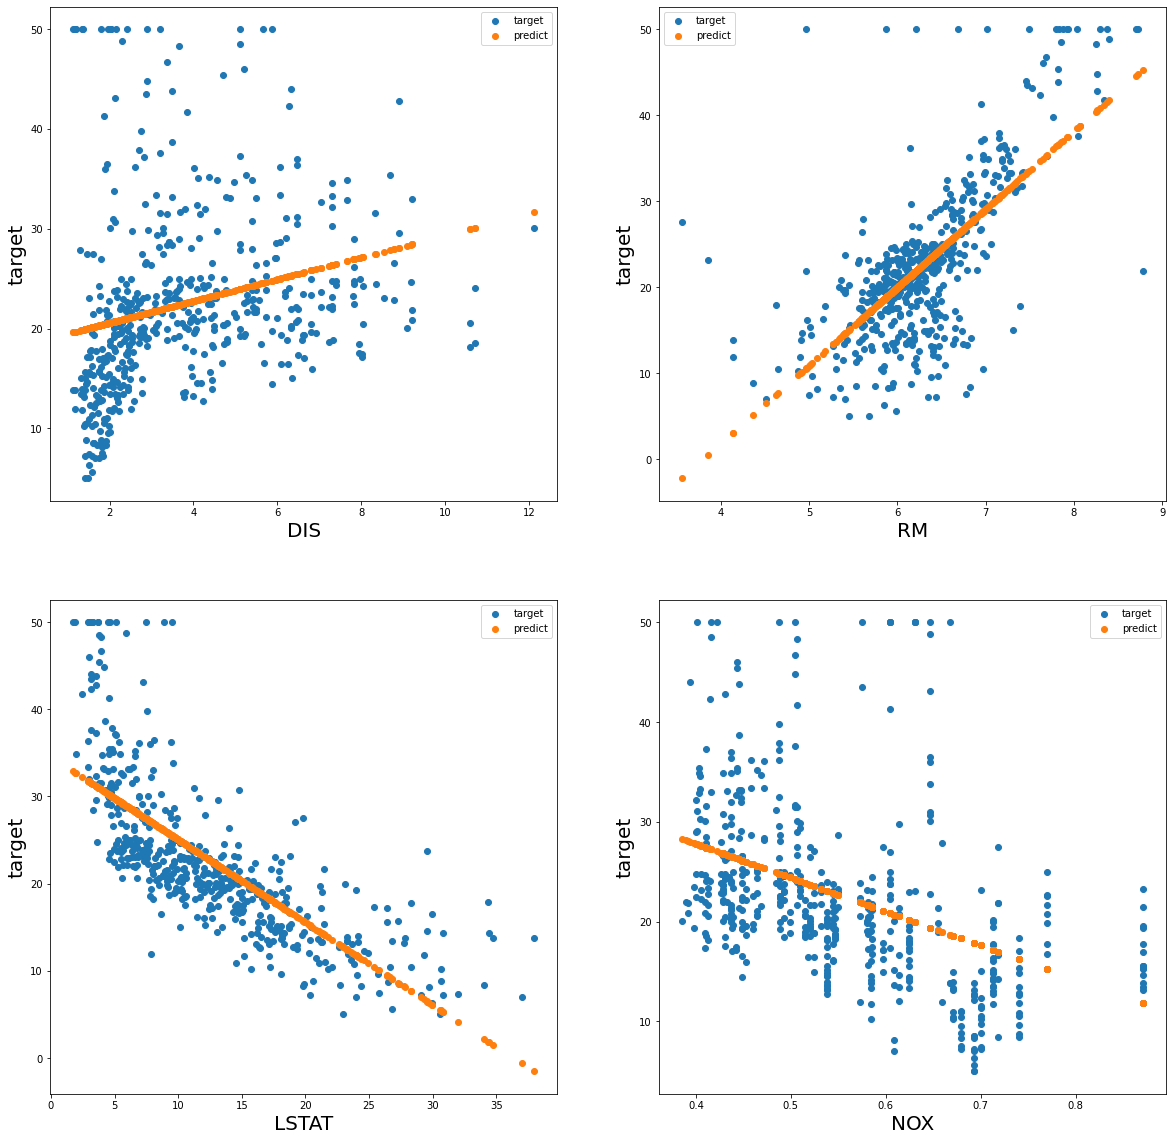

In [32]:
show_on_features = ('DIS', 'RM', 'LSTAT', 'NOX')
n_plots = len(show_on_features)
grid_x, grid_y = 2, 2

plt.figure(figsize=(20, 20))
for i, feature_name in enumerate(show_on_features):
    plt.subplot(grid_x,  grid_y,  i + 1)
    model = LinearRegression()

    model.fit(x[[feature_name]], y)

    predict = model.predict(x[[feature_name]])

    plt.scatter(x[[feature_name]], y, label='target')
    plt.scatter(x[[feature_name]], predict, label='predict')
    plt.ylabel('target', fontsize=20)
    plt.xlabel(feature_name, fontsize=20)
    plt.legend()

Провернем трюк, основанный на следующем:

Если дать бедному и богатому по 1000р., то скорее всего бедный сильно обрадуется, а богатый даже не заметит.

Т.е. деньги - это такая величина, у которой обычно хочется смотреть на порядок (если и бедному и богатому удвоить их состояния, то скорее всего они оба обрадуются)

Давайте попробуем сейчас тоже затачиваться не на разницу, а на порядок. Что для этого нужно поменять в предыдущем коде?
<details> 
    <summary markdown="span">Ответ</summary>
    1. Будем обучаться на $log(y)$ <br/>
    2. Тогда наша модель будет предсказывать логарифмы. Значит просто возьмем экспоненту!
    
</details>

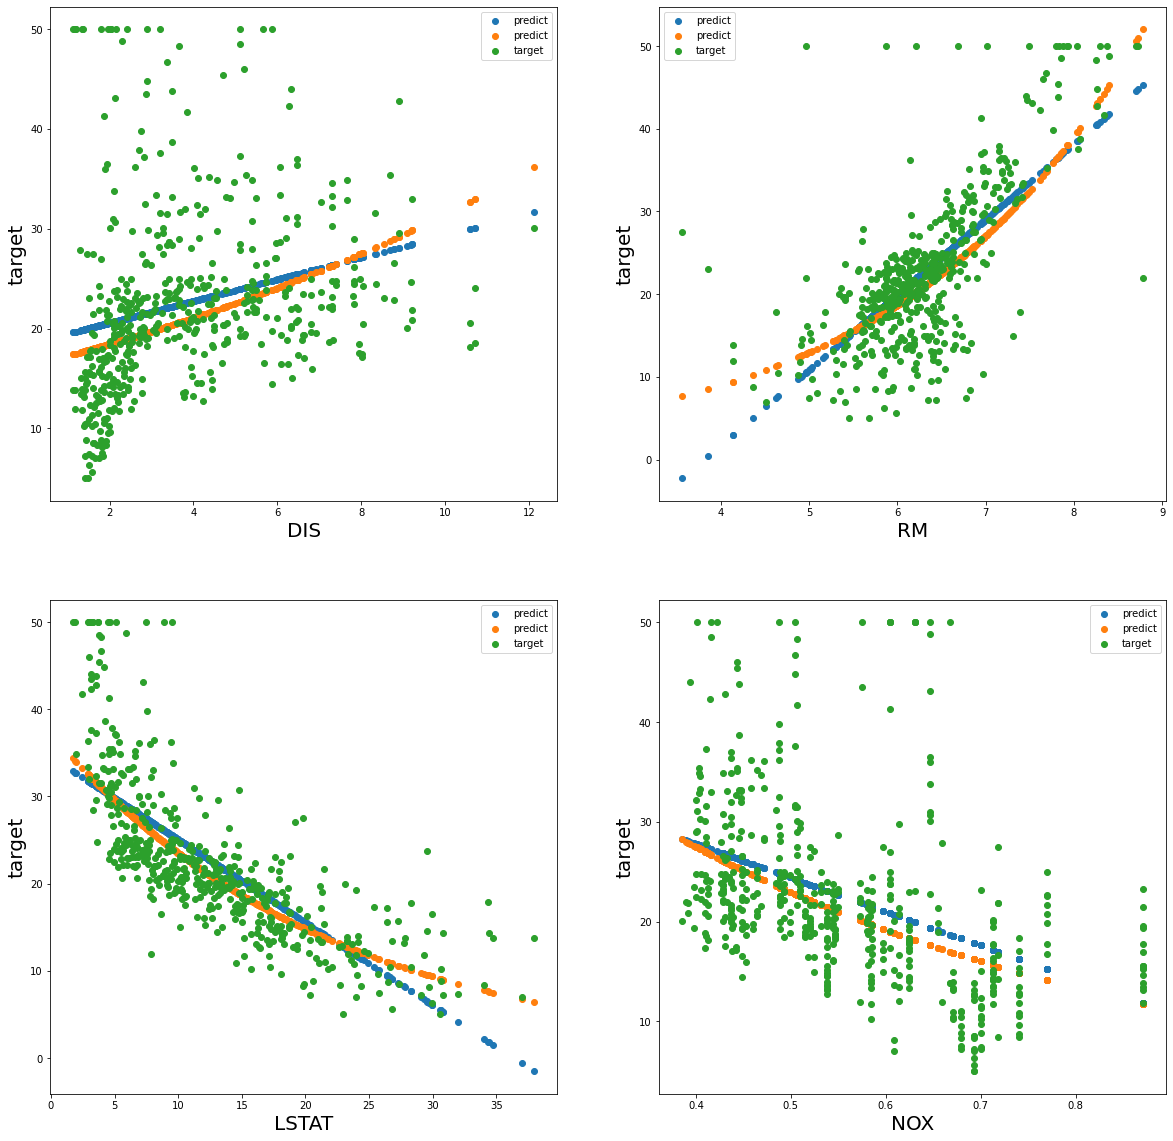

In [33]:
show_on_features = ('DIS', 'RM', 'LSTAT', 'NOX')
n_plots = len(show_on_features)
grid_x, grid_y = 2, 2

plt.figure(figsize=(20, 20))
for i, feature_name in enumerate(show_on_features):
    plt.subplot(grid_x,  grid_y,  i + 1)
    model = LinearRegression()

    model.fit(x[[feature_name]], y)

    predict = model.predict(x[[feature_name]])
    plt.scatter(x[[feature_name]], predict, label='predict')
    
    model_log_y = LinearRegression()
    model_log_y.fit(x[[feature_name]], np.log(y))
    
    predict_log = model_log_y.predict(x[[feature_name]])
    predict = np.exp(predict_log)
    plt.scatter(x[[feature_name]], predict, label='predict')

    plt.scatter(x[[feature_name]], y, label='target')
    
    plt.ylabel('target', fontsize=20)
    plt.xlabel(feature_name, fontsize=20)
    plt.legend()

Т.е. иногда бывает полезно делать преобразования над таргетом, чтобы таргет лучше коррелировал с признаками.

Простой пример:

Если бы нам нужно было предсказывать функцию $y = x^2$ и в качестве признака мы бы брали только x:

In [34]:
x_example = np.linspace(0, 2)
y_example = x_example ** 2
y_observed = y_example + np.random.normal(0, 0.05, size=len(x_example)) # данные наблюдаем с небольшим шумом

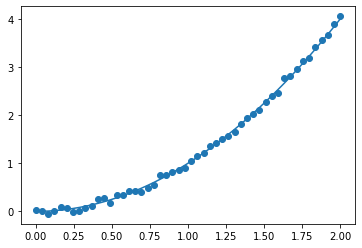

In [35]:
plt.scatter(x_example, y_observed)
plt.plot(x_example, y_example);

Обучим линрег:

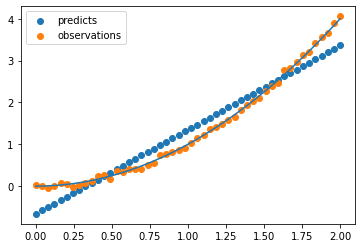

In [36]:
model = LinearRegression()
model.fit(x_example[:, None], y_observed)
predict = model.predict(x_example[:, None])

plt.scatter(x_example, predict, label='predicts')
plt.scatter(x_example, y_observed, label='observations')

plt.plot(x_example, y_example)
plt.legend();

Как-то не очень. А если от $y$-в сначала взять корень?

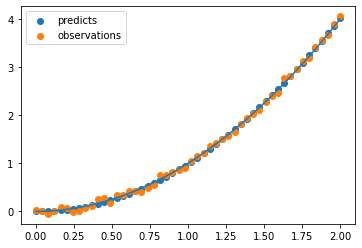

In [37]:
model = LinearRegression()
model.fit(x_example[:, None], np.sqrt(np.maximum(y_observed, 0)))
predict = model.predict(x_example[:, None]) ** 2

plt.scatter(x_example, predict, label='predicts')
plt.scatter(x_example, y_observed, label='observations')

plt.plot(x_example, y_example)
plt.legend();

А сработает ли такой трюк для этой же параболы, но на отрезке (-1, 1)? Почему?

<details> 
    <summary markdown="span">Ответ</summary>
    Если просто взять корень, то мы получим модуль, который не является прямой
    
</details>

Но более частый прием - это преобразовывать не таргет, а признаки. Т.е. мы, например, можем в этой задаче сгенерировать из признака $x$ признак $x^2$, а таргет совсем не трогать

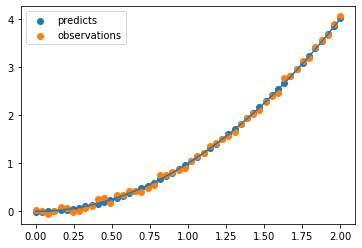

In [38]:
model = LinearRegression()
model.fit(x_example[:, None] ** 2, np.maximum(y_observed, 0))
predict = model.predict(x_example[:, None] ** 2)

plt.scatter(x_example, predict, label='predicts')
plt.scatter(x_example, y_observed, label='observations')

plt.plot(x_example, y_example)
plt.legend();

Преобразовывать признаки или добавлять новые по существующим зачастую будет работать лучше, чем преобразовывать таргет, т.к. преобразованный таргет может стать лучше коррелировать с одной частью признаков, а на другой части все может ухудшиться.

Генерация и преобразование признаков - это тоже очень интересная тема, про которую поговорим попозже, но сейчас можно погуглить feature engineering

### Давайте теперь посмотрим на кросс-валидацию, если сделать трюк с логарифмом денег:

In [39]:
#  Приходится копипастить, чтобы в начале занятия не раскрыть все карты:)

def get_cv_score(
    model: tp.Any,
    x: pd.DataFrame,
    y: np.ndarray,
    n_folds: int,
    random_state: int,
    target_transforms: tp.Optional[tp.Dict[str, tp.Callable]] = None,
) -> tp.Tuple[dict, tp.Dict[str, float]]:
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    test_mses = []
    fold_infos = {}
    
    for fold_num, (train_indexes, test_indexes) in enumerate(kf.split(x)):
        x_train = x.iloc[train_indexes].reset_index(drop=True)
        y_train = y[train_indexes]
        
        x_test = x.iloc[test_indexes].reset_index(drop=True)
        y_test = y[test_indexes]
        
        x_train, x_test = scale_train_test(x_train, x_test)
        
        if target_transforms is not None:
            y_train = target_transforms['before_train'](y_train)
        model.fit(x_train, y_train)
        
        test_predict = model.predict(x_test)
        if target_transforms is not None:
            test_predict = target_transforms['after_predict'](test_predict)
        
        test_mse = mean_squared_error(y_test, test_predict)
        test_mses.append(test_mse)
        
        fold_infos[fold_num] = {
            'model': deepcopy(model),
            'test_mse': test_mse,
        }
    return fold_infos, np.mean(test_mses)

In [40]:
n_folds = 10

target_transforms = {
    'before_train': np.log,
    'after_predict': np.exp,
}

model = LinearRegression()

for random_state in range(10):
    _, cv_score = get_cv_score(model, x, y, n_folds, random_state)
    _, cv_score_with_transforms = get_cv_score(model, x, y, n_folds, random_state, target_transforms)
    print(f'MSE without transforms: {cv_score:.4f}, MSE with transforms: {cv_score_with_transforms:.4f}')

MSE without transforms: 23.7980, MSE with transforms: 19.9146
MSE without transforms: 23.7591, MSE with transforms: 19.7052
MSE without transforms: 23.3538, MSE with transforms: 19.5843
MSE without transforms: 23.8718, MSE with transforms: 19.9464
MSE without transforms: 23.7277, MSE with transforms: 19.7258
MSE without transforms: 24.2325, MSE with transforms: 19.8962
MSE without transforms: 23.4692, MSE with transforms: 19.6238
MSE without transforms: 23.7465, MSE with transforms: 19.8548
MSE without transforms: 23.7828, MSE with transforms: 19.9107
MSE without transforms: 23.5785, MSE with transforms: 19.6713


Стало однозначно лучше

### Давайте посмотрим на веса линейной регрессии:

In [41]:
model = LinearRegression()
fold_infos, _ = get_cv_score(model, x, y, n_folds=10, random_state=42, target_transforms=target_transforms)

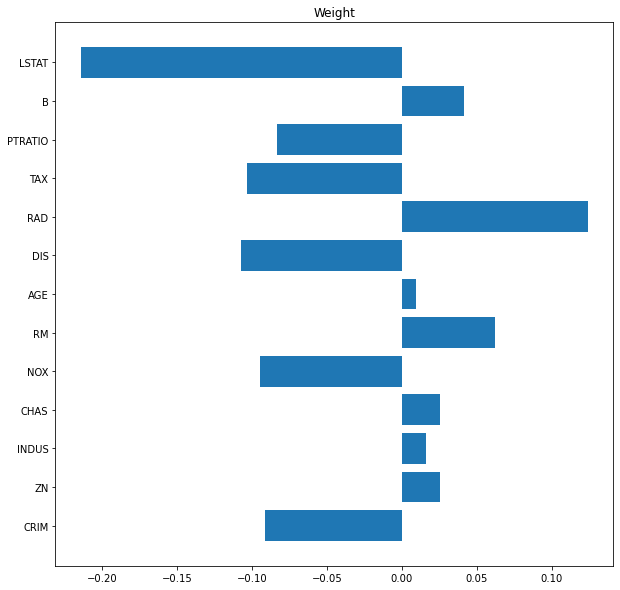

In [42]:
model = fold_infos[0]['model']
plt.figure(figsize=(10, 10))
plt.title('Weight')
plt.barh(x.columns, model.coef_);

### Регуляризация

In [43]:
from sklearn.linear_model import Ridge, Lasso

alpha - это гиперпараметр, от которого может сильно зависеть качество. Нужно его подбирать

на кросс-валидации. Например, по логарифмической сетке

In [49]:
model = Ridge(alpha=0) 
folds, score = get_cv_score(model, x, y, random_state=42, n_folds=10, target_transforms=target_transforms)
score

19.579274971968594

In [50]:
folds[0]['model'].coef_

array([-0.09170136,  0.02510133,  0.01634526,  0.02546843, -0.09451471,
        0.06212299,  0.0093761 , -0.10750261,  0.12424885, -0.10314868,
       -0.08323044,  0.04152696, -0.21428977])

In [55]:
model = Ridge(alpha=100) 
folds, score = get_cv_score(model, x, y, random_state=42, n_folds=10, target_transforms=target_transforms)
score

22.888263820199917

In [56]:
folds[0]['model'].coef_

array([-0.06736093,  0.00650251, -0.01410544,  0.02944627, -0.04382543,
        0.08423951, -0.00966864, -0.05331099,  0.0212034 , -0.03179569,
       -0.0630791 ,  0.03976055, -0.15476657])

## Логистическая регрессия

Будем предсказывать, стоит ли квартира выше/ниже медианной цены

In [57]:
y_cls = (y > np.median(y)).astype(int)

In [58]:
y_cls.mean()

0.49407114624505927

Почему среднее значение так подозрительно близко к 0.5?:)

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
model = LogisticRegression()

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y_cls, test_size=0.2, random_state=42)

In [62]:
model.fit(x_train, y_train)

/Users/artemkravchuk/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [63]:
model.predict(x_test)

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [64]:
y_test

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [65]:
model.predict_proba(x_test)[:10]

array([[0.11702608, 0.88297392],
       [0.01179298, 0.98820702],
       [0.9230488 , 0.0769512 ],
       [0.16906858, 0.83093142],
       [0.72629716, 0.27370284],
       [0.63138569, 0.36861431],
       [0.89713157, 0.10286843],
       [0.98431909, 0.01568091],
       [0.39841463, 0.60158537],
       [0.66086941, 0.33913059]])

In [66]:
from sklearn.metrics import accuracy_score

In [67]:
accuracy_score(y_test, model.predict(x_test))

0.8431372549019608

Проверим, что моделька не предсказывает погоду и работает лучше рандома

In [68]:
random_predict = np.random.binomial(1, 0.5, size=len(x_test))

In [69]:
random_predict

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0])

In [70]:
accuracy_score(y_test, random_predict)

0.38235294117647056

Угу, превзошли